In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import distinct
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\wwoli\AppData\Local\Temp\ipykernel_20384\4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
mr_date = session.query(func.max(Measurement.date)).scalar()

print(mr_date)

2017-08-23


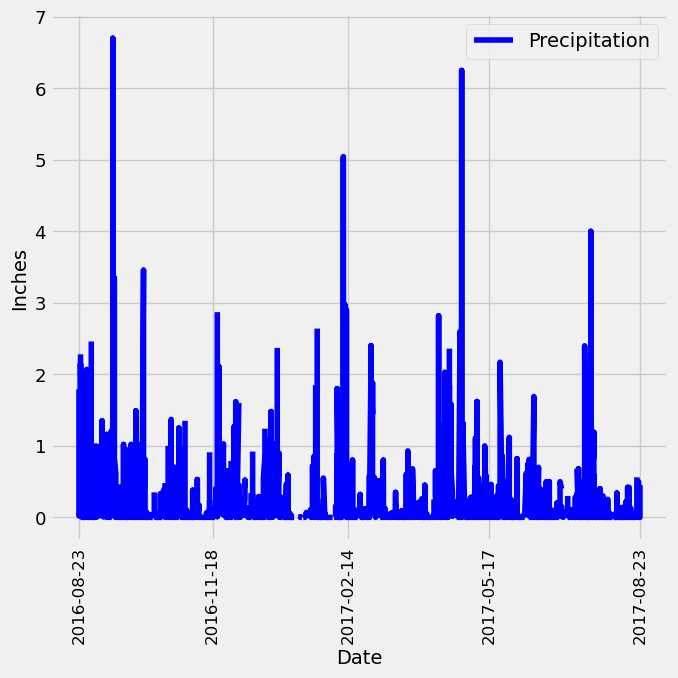

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
mr_date_12 = dt.datetime.strptime(mr_date, '%Y-%m-%d').date()
# Starting from the most recent data point in the database. 
m_recent = mr_date_12 - dt.timedelta(days=365)
# Calculate the date one year from the last date in data set.
m_recent = dt.datetime.strptime(mr_date, '%Y-%m-%d').date() - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
p_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= m_recent).\
    filter(Measurement.date <= mr_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
p_df = pd.DataFrame(p_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
p_df.sort_values(by='Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(7,7))
plt.plot(p_df['Date'], p_df['Precipitation'], label='Precipitation', color='blue')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Inches', fontsize=14)
plt.xticks(p_df['Date'][::(len(p_df) // 4)], rotation=90, fontsize=12)
plt.yticks(fontsize=13)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
p_summary = p_df['Precipitation'].describe()
print(p_summary)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
stations = session.query(func.count(distinct(Station.station))).scalar()
print(stations)

9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [Measurement.station,func.count(Measurement.id)]
activestations = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
activestations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
mostactivestationdata = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()
mostactivestationdata

(54.0, 85.0, 71.66378066378067)

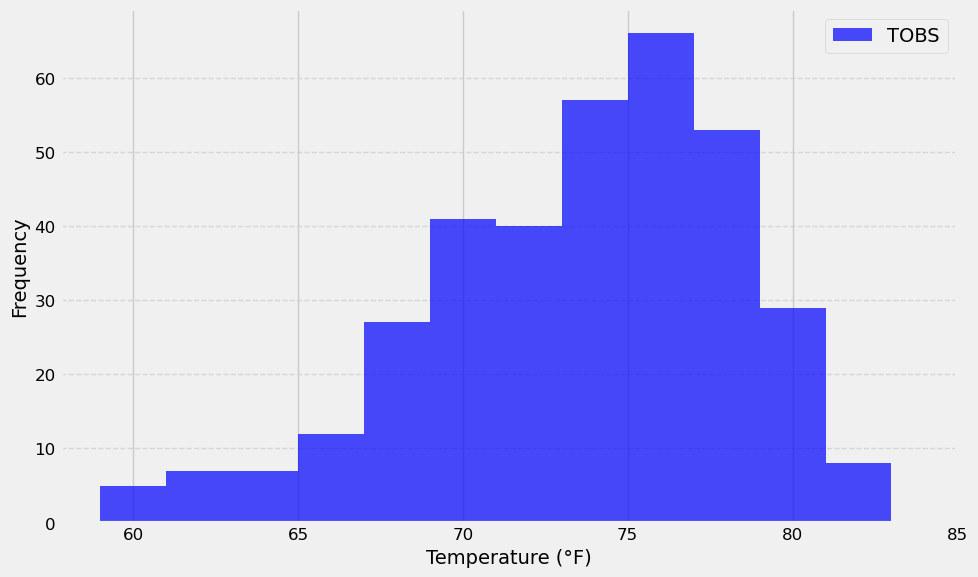

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Extract the most active station ID from the previous query result
ma_station_id = activestations[0][0]

# Query the last 12 months of temperature observation data for the most active station
temperature_data = session.query(Measurement.tobs).\
                    filter(Measurement.station == ma_station_id).\
                    filter(Measurement.date >= m_recent).all()

# Extract temperatures from the result
temperatures = [temp[0] for temp in temperature_data]

# Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temperatures, bins=12, color='blue', alpha=0.7,label='TOBS')
plt.xlabel('Temperature (°F)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(np.arange(60, 90, 5), fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()